# Reinforcement Learning Agent for Statistical Arbitrage

This notebook demonstrates how to configure and train a reinforcement learning agent for statistical arbitrage using a snapshot model. The agent will learn to identify and exploit statistical arbitrage opportunities in financial markets.

## Install necessary libraries

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# %pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tensorboard

## Configuration

The configuration section sets up the parameters for the reinforcement learning model.

In [2]:
CONFIG = {
    "DATA": {
        "forward_fill": True,
        "drop_na_after_ffill": True,
        "cache_dir": "./data_cache",
        "timestamp_format": "%Y-%m-%d %H:%M:%S",
        "asset_price_format": "{ASSET}_close",
        "pair_feature_format": "{ASSET1}_{ASSET2}_{FEATURE}",
        "timestamp_col": "timestamp",
        "file_names": {
            "features": "bin_futures_historical_pairs_with_spreads_normalized"
        },
        "file_ids": {
            "price_folder_id": "1uXEBUyySypdsW_ZqL-RZ3d1bWdIZisij",
            "ADA_1h": "1ydaR3T68ReE_7j5t3wZbj0F-zdRPYoxg",
            "APT_1h": "1CxG9N2bqWPs9fOPOUryYNtHmONXo4SRi",
            "ARB_1h": "136FSMlAW3XHG8WocxxTEcSKiLMUBwWMi",
            "ATOM_1h": "1mhSQgEwRHn3nvu8Qu1ctQGzdW5JuxATR",
            "BTC_1h": "1-sBNQpEFGEpVO3GDFCkSZiV3Iaqp2vB_",
            "DOGE_1h": "14XlkoQMYr8WWecGninAKUavvjB3qNxk0",
            "DOT_1h": "1kCWB4ZZu3FnadbAquTa3Rcdcwkhnq6-s",
            "ENA_1h": "1TYTxexlD24cs7qmhyVoTacX7lqGOsfky",
            "ETC_1h": "1coBd9QiEX03MndMgX5_549mOPyY23ZcI",
            "ETH_1h": "1kj8G1scpFuEYTTXKEUzF9pwgGI2WFFL9",
            "HBAR_1h": "1LVseecBvXKl3Wl9hbPLsROYKR1Gp8zhQ",
            "LINK_1h": "1ZLEraxdV3H8jpf1FmPeVs1ySL7TzMvH5",
            "LTC_1h": "18d3_jD-tuYTQQR2QOwXupckeDgqvAIvx",
            "NEAR_1h": "1PqI2hD2gbDxUaRDPnJpvDNH5wPYv47G6",
            "SOL_1h": "17CjYYSEsTEqBdmm51zGLgmpkslxxjiji",
            "SUI_1h": "1bToOJts-x2Ia48tqXcMs4qFIQ5OV1lAP",
            "TON_1h": "1SARYo5zB6AunG82kw7KGF4Nird3lQ4zB",
            "TRX_1h": "1FlcZo1WRtKFQMbBrsb61Lp3_pplISW4U",
            "UNI_1h": "15L-eKWliyg9MBKuznlZZ-FJzm52Ovt20",
            "WLD_1h": "1XqD1K4-YZzPxYFHKHY3KmKWnnwi3zO20",
            "XLM_1h": "1_3E5-mORLWh3X16Hi0ccHwzVKg5QxoT4",
            "XRP_1h": "1crt2g_t0qpYnaGpcozl35yDeHhd4tmi4",
            "features": "1WA4z47rHoXhPsJALxLHLEXIl9nYpj-G-"
        }
    },
    "COINTEGRATION": {
        "training_window_days": 2,
    },
    "ENV": {
        "include_cash": True,
        "shorting": True,
        "trading_window_days": "2D",
        "sliding_window_step": "1D",
        "lookback_window": 24,  # Reduced from 32 to just 1 day of hourly data
        "transaction_costs": {
            "commission_bps": 5.0,
            "slippage_bps": 5.0,
        },
        "reward": {
            "risk_lambda": 0.001
        },
        "leverage": {
            "use_leverage": True,
            "long_cap": 1.0,
            "short_cap": 1.0,
            "use_asymmetric": False,
        },
        "constraints": {
            "min_weight": -1.0,
            "max_weight": 1.0,
            "sum_to_one": False
        },
        "seed": 42
    },
    "SPLITS": {
        "data_start": "2024-05-01",
        "data_end": "2025-04-30",
        "train": ["2024-05-01","2024-05-15"],
        "val": ["2024-05-16","2024-05-23"],
    },
    "RL": {
        "timesteps": 1000,
        "policy": "MlpPolicy",
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "n_steps": 64,
        "batch_size": 32,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5
    },
    "EVAL": {
        "plots": True,
        "reports_dir": "./reports"
    },
    "IO": {
        "models_dir": "./models",
        "tb_logdir": "./tb_logs"
    }
}

## Imports

In [3]:
import os
import json
import gdown
import math
import glob
import random
import pytz
import csv

import time

from datetime import timedelta, datetime

from typing import Iterable, Tuple, Dict, List, Set, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

# Deep Learning
import torch

print("Imports complete.")

Imports complete.


## Helper Functions

In [4]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [5]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [6]:
def set_all_seeds(seed: int = 42):
    random.seed(seed) # seed for random module
    np.random.seed(seed) # seed for numpy module
    try:
        torch.manual_seed(seed) # seed for torch module
        if torch.cuda.is_available(): # seed for CUDA device
            torch.cuda.manual_seed_all(seed)
        elif torch.backends.mps.is_available(): # seed for Apple Silicon device
            torch.backends.mps.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [7]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"File {file_name} already exists in cache. Skipping download.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = gdown.download(url, out_path, quiet=False, use_cookies=False, verify=False)
        return success
    except Exception as e:
        print(f"Download attempt failed for {file_name}. Error: {str(e)}")
    
# donwload features
file_name = CONFIG["DATA"]["file_names"]["features"]
file_id = CONFIG["DATA"]["file_ids"]["features"]
cache_dir = CONFIG["DATA"]["cache_dir"]

print("Downloading cointegration data...")
success = download_file(file_name, file_id, cache_dir)
print("Download complete.")

File bin_futures_historical_pairs_with_spreads_normalized already exists in cache. Skipping download.
Download complete.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [8]:
def load_csv_to_df(
    path: str,
    parse_timestamp_col: str | None = "timestamp",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """
    # Try delimiter sniffing first
    with open(path, "r", encoding=encoding, newline="") as f:
        sample = f.read(2048)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[",",";","|","\t"])
        sep = dialect.delimiter
    except csv.Error:
        sep = ","  # fallback

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)
    if parse_timestamp_col and parse_timestamp_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [parse_timestamp_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="python", **read_csv_kwargs)
    return df


# load features
file_name = CONFIG["DATA"]["file_names"]["features"]
cache_dir = CONFIG["DATA"]["cache_dir"]
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, parse_timestamp_col="timestamp")

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Columns: 392 entries, AAVE_close to BTC_TRX_spread_norm
dtypes: datetime64[ns](1), float64(391)
memory usage: 1.5 GB
None


## Identify Feature Structure

In [9]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str
    ) -> tuple[list[str], list[str], list[tuple[str, str]]]:
    """
    ----------
    Identify:
      - Distinct assets from columns matching `single_asset_format`
      - Distinct features from columns matching `pair_feature_format`
      - Distinct unordered asset pairs found in cross-asset feature columns

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe whose columns follow the naming conventions.
    single_asset_format : str
        Format string describing single-asset columns (e.g., "{ASSET}_close").
    pair_feature_format : str
        Format string describing pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").

    Returns
    -------
    (assets, features, asset_pairs)
        assets       : sorted list[str] of unique asset tickers (from single asset columns)
        features     : sorted list[str] of unique feature names
        asset_pairs  : sorted list[tuple[str, str]] of unique unordered pairs
    """

    # Build regex patterns from format strings
    # Example: "{ASSET}_close" → r"^(?P<ASSET>[A-Za-z0-9]+)_close$"
    def format_to_regex(fmt: str) -> re.Pattern:
        pattern = re.escape(fmt)
        # Replace placeholders like {ASSET}, {ASSET1}, {FEATURE}
        pattern = re.sub(r"\\\{(\w+)\\\}", r"(?P<\1>[A-Za-z0-9]+)", pattern)
        return re.compile(f"^{pattern}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)

    assets: Set[str] = set()
    features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    for col in df.columns:
        if col == "timestamp":
            continue

        # Try single-asset pattern
        m1 = single_asset_pattern.match(col)
        if m1:
            assets.add(m1.group("ASSET"))
            continue

        # Try pair-feature pattern
        m2 = pair_feature_pattern.match(col)
        if m2:
            a1, a2, feat = m2.group("ASSET1"), m2.group("ASSET2"), m2.group("FEATURE")
            pair = tuple(sorted((a1, a2)))
            assets.update([a1, a2])
            pairs.add(pair)
            features.add(feat)

    return sorted(assets), sorted(features), sorted(pairs)

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, features, asset_pairs = identify_assets_features_pairs(
    features_df,
    single_asset_format,
    pair_feature_format
    )

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(features)} features: {features}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 4 features: ['alpha', 'beta', 'corr', 'spread']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('BCH', 'DOT'), ('BCH', 'ENA'), ('BCH', 'ETC'), ('BNB', 'LINK'), ('BTC', 'DOGE'), ('BTC', 'HBAR'), ('BTC', 'LTC'), ('BTC', 'SUI'), ('BTC', 'TRX'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('DOGE', 'LINK'), ('DOGE', 'LTC'), ('DOGE', 'SUI'), ('DOGE', 'XLM'), ('DOT', 'ENA'), ('DOT', 'ETC'), ('DOT', 'ETH

## Build Time Intervals

In [10]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "timestamp",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 363 time intervals with window=2D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-03 00:00:00
  2024-05-02 00:00:00 to 2024-05-04 00:00:00
  2024-05-03 00:00:00 to 2024-05-05 00:00:00


## Identify Feature Space

In [11]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str = "spread",
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str = "timestamp"
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """

    asset1, asset2 = pair

    # Construct expected column names
    feature_col_name = pair_feature_format.format(ASSET1=asset1, ASSET2=asset2, FEATURE=feature_name)

    # Filter DataFrame to the specified time frame
    mask = (df[timestamp_col] >= start) & (df[timestamp_col] < end)
    df_timeframe = df.loc[mask, [timestamp_col, feature_col_name]]

    # Check for missing values in any of the required columns
    if df_timeframe.isnull().values.any():
        return False

    return True

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name="spread",
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals
    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")

print("First 3 valid intervals for first 3 pairs:")
for pair in list(valid_intervals_per_pair.keys())[:3]:
    print(f"Pair {pair}:")
    for start, end in valid_intervals_per_pair[pair][:3]:
        print(f"  {start} to {end}")

Pair ('AAVE', 'SUI') has 35 valid intervals out of 363 total intervals.
Pair ('AAVE', 'TRX') has 10 valid intervals out of 363 total intervals.
Pair ('AAVE', 'TRX') has 10 valid intervals out of 363 total intervals.
Pair ('ADA', 'BTC') has 51 valid intervals out of 363 total intervals.
Pair ('ADA', 'BTC') has 51 valid intervals out of 363 total intervals.
Pair ('ADA', 'DOGE') has 52 valid intervals out of 363 total intervals.
Pair ('ADA', 'DOGE') has 52 valid intervals out of 363 total intervals.
Pair ('ADA', 'HBAR') has 85 valid intervals out of 363 total intervals.
Pair ('ADA', 'HBAR') has 85 valid intervals out of 363 total intervals.
Pair ('ADA', 'LTC') has 56 valid intervals out of 363 total intervals.
Pair ('ADA', 'LTC') has 56 valid intervals out of 363 total intervals.
Pair ('ADA', 'SUI') has 38 valid intervals out of 363 total intervals.
Pair ('ADA', 'SUI') has 38 valid intervals out of 363 total intervals.
Pair ('ADA', 'XLM') has 53 valid intervals out of 363 total intervals.

## Feature Panel Creation

In [12]:
def create_feature_panel(df: pd.DataFrame, assets: list[str], features: list[str], 
                     single_asset_format: str, pair_feature_format: str):
    """
    Create a feature panel from the dataframe containing pre-normalized single-asset and pair features.
    """
    panel_cols = []
    panel_data = []
    
    # First, ensure we have the timestamp column
    if 'timestamp' not in df.columns:
        raise ValueError("DataFrame must have a 'timestamp' column")
        
    # Add single-asset features
    for asset in assets:
        price_col = single_asset_format.format(ASSET=asset)
        if price_col in df.columns:
            panel_data.append(df[price_col])
            panel_cols.append((asset, 'price'))

    # Add pair features
    for asset1, asset2 in asset_pairs:
        for feature in features:
            col = pair_feature_format.format(ASSET1=asset1, ASSET2=asset2, FEATURE=feature)
            if col in df.columns:
                panel_data.append(df[col])
                panel_cols.append((f"{asset1}_{asset2}", feature))

    # Create panel
    panel = pd.concat(panel_data, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_cols, names=['asset', 'feature'])
    
    # Add timestamp column and set it as index
    panel['timestamp'] = df['timestamp']
    panel = panel.set_index('timestamp')
    
    return panel.fillna(0)  # Fill NaN values with 0

# Create feature panel
panel = create_feature_panel(
    features_df,
    assets,
    features,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"]
)

print("Feature panel structure:")
print("\nColumns:", panel.columns.tolist())
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

Feature panel structure:

Columns: [('AAVE', 'price'), ('ADA', 'price'), ('APT', 'price'), ('ARB', 'price'), ('ATOM', 'price'), ('AVAX', 'price'), ('BCH', 'price'), ('BNB', 'price'), ('BTC', 'price'), ('DOGE', 'price'), ('DOT', 'price'), ('ENA', 'price'), ('ETC', 'price'), ('ETH', 'price'), ('HBAR', 'price'), ('LINK', 'price'), ('LTC', 'price'), ('NEAR', 'price'), ('SUI', 'price'), ('TON', 'price'), ('TRX', 'price'), ('UNI', 'price'), ('WLD', 'price'), ('XLM', 'price'), ('XRP', 'price'), ('AAVE_SUI', 'alpha'), ('AAVE_SUI', 'beta'), ('AAVE_SUI', 'corr'), ('AAVE_SUI', 'spread'), ('AAVE_TRX', 'alpha'), ('AAVE_TRX', 'beta'), ('AAVE_TRX', 'corr'), ('AAVE_TRX', 'spread'), ('ADA_BTC', 'alpha'), ('ADA_BTC', 'beta'), ('ADA_BTC', 'corr'), ('ADA_BTC', 'spread'), ('ADA_DOGE', 'alpha'), ('ADA_DOGE', 'beta'), ('ADA_DOGE', 'corr'), ('ADA_DOGE', 'spread'), ('ADA_HBAR', 'alpha'), ('ADA_HBAR', 'beta'), ('ADA_HBAR', 'corr'), ('ADA_HBAR', 'spread'), ('ADA_LTC', 'alpha'), ('ADA_LTC', 'beta'), ('ADA_LTC', '

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [13]:
def build_state_tensor_for_interval(panel: pd.DataFrame, pair: tuple, start: pd.Timestamp, 
                            end: pd.Timestamp, lookback: int):
    """
    Build state tensor for a specific time interval and asset pair.
    """
    # Get relevant columns for this pair
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"
    
    # Get all features for this pair
    pair_columns = [col for col in panel.columns if col[0] == pair_str]
    # Convert list comprehension to numpy array before using unique
    features = pd.unique(np.array([col[1] for col in pair_columns]))
    
    # Convert index to DatetimeIndex if it isn't already
    if not isinstance(panel.index, pd.DatetimeIndex):
        if 'timestamp' in panel.columns:
            panel = panel.set_index('timestamp')
        else:
            raise ValueError("Panel must have either a DatetimeIndex or a 'timestamp' column")
    
    # Ensure index is timezone-aware UTC
    if panel.index.tz is None:
        panel.index = panel.index.tz_localize('UTC')
    elif panel.index.tz != pytz.UTC:
        panel.index = panel.index.tz_convert('UTC')
    
    # Ensure start and end are timezone-aware UTC
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    
    # Create mask for time window
    mask = (panel.index >= start) & (panel.index <= end)
    window_data = panel.loc[mask, pair_columns]

    if len(window_data) < lookback + 1:
        return None, None, None
    
    # Prepare dimensions
    n_samples = len(window_data) - lookback
    n_features = len(features)
    
    # Initialize tensors
    X = np.zeros((n_samples, 1, n_features, lookback), dtype=np.float32)  # 1 for single pair
    R = np.zeros((n_samples, 1), dtype=np.float32)
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    
    # Convert to numpy for faster operations
    data_values = window_data.values
    
    # Pre-compute feature indices
    feature_to_idx = {feat: idx for idx, feat in enumerate(features)}
    spread_idx = feature_to_idx.get('spread')
    
    if spread_idx is not None:
        # Efficiently fill tensors using numpy operations
        for t in range(n_samples):
            # Fill features
            for j, feature in enumerate(features):
                X[t, 0, j, :] = data_values[t:t+lookback, feature_to_idx[feature]]
            
            # Calculate returns and volatility using spread
            curr_spread = data_values[t+lookback-1, spread_idx]
            next_spread = data_values[t+lookback, spread_idx]
            R[t, 0] = next_spread - curr_spread
            VOL[t, 0] = abs(curr_spread)
    
    return X, R, VOL

# Initialize lists to store tensors and metadata
all_X, all_R, all_VOL = [], [], []
all_pairs = []
all_features = set()
all_timestamps = []
ticker_set = set()  # Keep track of unique tickers

# Process each pair and its valid intervals
total_pairs = len(valid_intervals_per_pair)
for pair_idx, (pair, intervals) in enumerate(valid_intervals_per_pair.items(), 1):
    print(f"\nProcessing pair {pair} ({pair_idx}/{total_pairs})...")
    
    # Add both assets to the ticker set
    ticker_set.update(pair)
    
    skipped_intervals = 0
    valid_intervals = 0
    for interval_idx, (start, end) in enumerate(intervals, 1):
        
        X, R, VOL = build_state_tensor_for_interval(
            panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
        )
        
        if X is not None:
            all_X.append(X)
            all_R.append(R)
            all_VOL.append(VOL)
            all_pairs.append(pair)
            # Get features for this pair
            pair_str = f"{pair[0]}_{pair[1]}"
            pair_features = [col[1] for col in panel.columns if col[0] == pair_str]
            all_features.update(pair_features)
            all_timestamps.append((start, end))

            valid_intervals += 1
        else:
            skipped_intervals += 1
    print(f"Finished pair {pair}. Valid intervals: {valid_intervals}, Skipped intervals: {skipped_intervals}, Total: {len(intervals)}")

# Combine all tensors
if all_X:
    X_all = np.concatenate(all_X, axis=0)
    R_all = np.concatenate(all_R, axis=0)
    VOL_all = np.concatenate(all_VOL, axis=0)
    FEAT_ORDER = sorted(list(all_features))
    TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers
    
    print("\nFinal tensor shapes:")
    print(f"X (states): {X_all.shape}")
    print(f"R (returns): {R_all.shape}")
    print(f"VOL (volatilities): {VOL_all.shape}")
    print(f"\nTotal pairs processed: {len(all_pairs)}")
    print(f"Features: {FEAT_ORDER}")
    print(f"Tickers: {TICKER_ORDER}")
    print(f"Time intervals processed: {len(all_timestamps)}")
    
    # Print actual date range of processed data
    if all_timestamps:
        all_starts = [start for start, _ in all_timestamps]
        all_ends = [end for _, end in all_timestamps]
        print(f"\nActual data range: {min(all_starts)} to {max(all_ends)}")
else:
    print("No valid data found for any pair and interval")


Processing pair ('AAVE', 'SUI') (1/61)...
Finished pair ('AAVE', 'SUI'). Valid intervals: 35, Skipped intervals: 0, Total: 35

Processing pair ('AAVE', 'TRX') (2/61)...
Finished pair ('AAVE', 'TRX'). Valid intervals: 10, Skipped intervals: 0, Total: 10

Processing pair ('ADA', 'BTC') (3/61)...
Finished pair ('AAVE', 'SUI'). Valid intervals: 35, Skipped intervals: 0, Total: 35

Processing pair ('AAVE', 'TRX') (2/61)...
Finished pair ('AAVE', 'TRX'). Valid intervals: 10, Skipped intervals: 0, Total: 10

Processing pair ('ADA', 'BTC') (3/61)...
Finished pair ('ADA', 'BTC'). Valid intervals: 51, Skipped intervals: 0, Total: 51

Processing pair ('ADA', 'DOGE') (4/61)...
Finished pair ('ADA', 'BTC'). Valid intervals: 51, Skipped intervals: 0, Total: 51

Processing pair ('ADA', 'DOGE') (4/61)...
Finished pair ('ADA', 'DOGE'). Valid intervals: 52, Skipped intervals: 0, Total: 52

Processing pair ('ADA', 'HBAR') (5/61)...
Finished pair ('ADA', 'DOGE'). Valid intervals: 52, Skipped intervals: 0

## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [14]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create simple train/val split based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")

    # Create splits for training
    SPLITS = [{
        "name": "DateSplit",
        "train": train_mask,
        "val": val_mask
    }]
except ValueError as e:
    print("\nError creating splits:", str(e))
    print("\nPlease check your date ranges in CONFIG:")
    print(f"Train: {CONFIG['SPLITS']['train']}")
    print(f"Validation: {CONFIG['SPLITS']['val']}")
    print(f"Data available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")


Training windows: 20161 timesteps
Training period: 2024-05-01 00:00:00+00:00 to 2024-05-15 00:00:00+00:00

Validation windows: 10081 timesteps
Validation period: 2024-05-16 00:00:00+00:00 to 2024-05-23 00:00:00+00:00


## Environment Configuration

This is a custom Gymnasium environment for portfolio optimization.

In [15]:
class PortfolioWeightsEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X # state tensor (samples, pairs, features, lookback)
        self.R = R # next period returns (samples, pairs)
        self.VOL = VOL # current period volatilities (samples, pairs)
        self.tickers = tickers # list of assets
        self.lookback = lookback # lookback window
        self.cfg = cfg_env # environment configuration taken from CONFIG

        # We'll work with just the first pair for now
        self.active_pair_idx = 0
        
        self.n_assets = 2  # Since we're working with pairs, we only need 2 assets at a time
        self.include_cash = cfg_env["include_cash"]
        self.shorting = cfg_env["shorting"]
        self.dim_action = self.n_assets + (1 if self.include_cash else 0)

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset
        obs_dim = n_features * lookback  # observation dimension for one pair
        
        print(f"Features per asset: {n_features}")
        print(f"Observation dimension: {obs_dim}")
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        print(f"Observation space shape: {self.observation_space.shape}")
        
        # Update action space for 2 assets + optional cash
        if self.shorting:
            self.action_space = spaces.Box(
                low=-cfg_env["leverage"]["short_cap"],
                high=cfg_env["leverage"]["long_cap"],
                shape=(self.dim_action,),
                dtype=np.float32
            )
        else:
            self.action_space = spaces.Box(
                low=0.0,
                high=cfg_env["leverage"]["long_cap"],
                shape=(self.dim_action,),
                dtype=np.float32
            )

        print(f"Action space shape: {self.action_space.shape}")

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.risk_lambda = cfg_env["reward"]["risk_lambda"]

        self.long_cap = cfg_env["leverage"]["long_cap"]
        self.short_cap = cfg_env["leverage"]["short_cap"]
        self.use_asymmetric = cfg_env["leverage"]["use_asymmetric"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _to_obs(self, t):
        # Get features for the current active pair only
        arr = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        return arr
    
    def _project_weights(self, a):
        if self.use_asymmetric:
            w = np.clip(a, -self.short_cap if self.shorting else 0.0, self.long_cap)
        else:
            max_leverage = max(self.long_cap, self.short_cap)
            w = np.clip(a, -max_leverage if self.shorting else 0.0, max_leverage)
        return w

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.zeros(self.dim_action)
        if self.include_cash:
            self.w[-1] = 1.0  # start with all cash
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        w_target = self._project_weights(action)
        turnover = np.sum(np.abs(w_target - self.w))
        trading_cost = (self.commission + self.slippage) * turnover

        asset_w_prev = self.w[:self.n_assets]  # 2-dimensional weights for the pair
        
        # Get returns and volatility for the active pair
        pair_return = self.R[self.t, self.active_pair_idx]
        pair_vol = self.VOL[self.t, self.active_pair_idx]
        
        # Calculate portfolio return and volatility for the pair
        asset_ret = pair_return * asset_w_prev[0]  # Simplified to first asset for now
        inst_vol = pair_vol * np.abs(asset_w_prev[0])  # Use absolute weight for volatility

        # reward function: asset return minus trading costs and risk penalty
        reward = asset_ret - trading_cost - self.risk_lambda * inst_vol

        self.portfolio_value *= math.exp(asset_ret - trading_cost)

        self.w = w_target
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        obs = np.clip(obs, -5.0, 5.0)
        
        leverage = np.sum(np.abs(self.w[:self.n_assets]))
        info = {
            "portfolio_value": self.portfolio_value, 
            "turnover": turnover, 
            "inst_vol": inst_vol, 
            "asset_ret": asset_ret,
            "total_leverage": leverage
        }
        return obs, reward, terminated, truncated, info

In [16]:
def slice_by_mask(X, R, VOL, mask: np.ndarray):
    # First, we need to expand the mask to match our tensor size
    # Each time point in our TIME_INDEX corresponds to multiple samples in our tensors
    # because we have multiple pairs per timestamp
    samples_per_timepoint = X.shape[0] // len(mask)
    
    # Expand the mask to match the tensor size
    expanded_mask = np.repeat(mask, samples_per_timepoint)
    idx = np.where(expanded_mask)[0]

    # If we have no valid indices, raise a ValueError
    if len(idx) == 0:
        raise ValueError("No data points available in the selected time period")
    
    return X[idx], R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    try:
        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, mask)

        env = PortfolioWeightsEnv(X_s, R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        env = Monitor(env, filename=None)
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise

Visualizing data splits timeline...


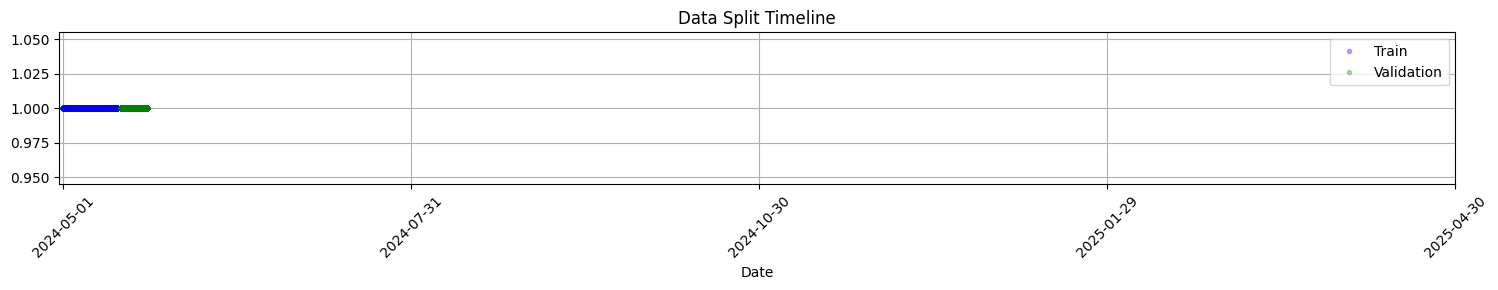

In [ ]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    if len(equity_curve) > 1:
        # Calculate years based on number of samples and sampling frequency
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            # If using RangeIndex, calculate based on sampling frequency
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    cummax = equity_curve.cummax()
    dd = (equity_curve / cummax - 1).min()
    maxdd = float(dd)
    calmar = mu / (abs(maxdd) + 1e-12)
    hit_ratio = (ret > 0).mean()
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    return {"CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino, "MaxDrawdown": maxdd, "Calmar": calmar, "Volatility": sigma, "Turnover": turnover, "HitRatio": hit_ratio}

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray):
    """Plot timeline showing training and validation periods."""
    plt.figure(figsize=(15,3))
    
    # Convert time index to numeric for plotting
    x = np.arange(len(time_index))
    
    # Plot splits
    plt.plot(x[train_mask], [1]*train_mask.sum(), 'b.', label='Train', alpha=0.3)
    plt.plot(x[val_mask], [1]*val_mask.sum(), 'g.', label='Validation', alpha=0.3)
    
    # Set x-axis ticks to show dates
    tick_locations = np.linspace(0, len(time_index)-1, 5, dtype=int)
    plt.xticks(tick_locations, time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45)
    
    plt.title("Data Split Timeline")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns, levs = [], [], []  # Initialize lists for portfolio value, turnover, and leverage
    
    for t in range(len(unwrapped.R)-1):
        if model is None:
            action = np.ones(unwrapped.dim_action)/unwrapped.dim_action
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        levs.append(info["total_leverage"])  # Track leverage from info dict
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    lev = pd.Series(levs, index=idx)  # Create leverage Series
    
    return ec, to, lev  # Return all three series

# Plot data splits
print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask)

In [18]:
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

RESULTS = []

for split in SPLITS:
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")

    vec_train = DummyVecEnv([lambda: train_env])
    vec_val = DummyVecEnv([lambda: val_env])

    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        learning_rate=CONFIG["RL"]["learning_rate"],
        ent_coef=CONFIG["RL"]["ent_coef"],
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device=device,
        verbose=1
    )

    eval_callback = EvalCallback(
        vec_val, 
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"], 
        eval_freq=10000,
        deterministic=True, 
        render=False
    )
    
    model.learn(total_timesteps=CONFIG["RL"]["timesteps"], callback=eval_callback)
    model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{split['name']}.zip")
    model.save(model_path)

    # Run validation
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")
    ec, to, lev = backtest_env(val_env, model=model)

    # Compare against equal weight strategy on validation set
    idx = np.where(split["val"])[0]
    R_val = R_all[idx]
    ew = np.ones(len(assets))/len(assets)  # equal weights
    ec_bench = [1.0]
    # Only iterate through the same number of returns as we have in ec.index
    for i in range(len(ec.index)-1):
        ec_bench.append(ec_bench[-1]*math.exp(np.dot(ew, R_val[i])))
    ec_bench = pd.Series(ec_bench, index=ec.index)

    # Calculate metrics
    m_model = compute_metrics(ec, CONFIG["DATA"]["sampling"], to)
    m_ew = compute_metrics(ec_bench, CONFIG["DATA"]["sampling"])

    # Add average leverage to model metrics
    m_model["Avg_Leverage"] = lev.mean()
    m_model["Max_Leverage"] = lev.max()

    RESULTS.append({
        "split": split["name"], 
        "model": m_model, 
        "equal_weight": m_ew
    })

    if CONFIG["EVAL"]["plots"]:
        plt.figure(figsize=(15, 12))
        
        # Plot equity curves
        plt.subplot(3, 1, 1)
        plt.plot(ec.index, ec.values, label='PPO')
        plt.plot(ec_bench.index, ec_bench.values, label='Equal-Weight')
        plt.title(f"Validation Equity Curves ({split['name']})")
        plt.xlabel("Time")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        
        # Plot drawdowns
        plt.subplot(3, 1, 2)
        plt.plot(ec.index, (ec / ec.cummax()) - 1.0, label='PPO')
        plt.plot(ec_bench.index, (ec_bench / ec_bench.cummax()) - 1.0, label='Equal-Weight')
        plt.title(f"Validation Drawdowns ({split['name']})")
        plt.xlabel("Time")
        plt.ylabel("Drawdown")
        plt.legend()
        plt.grid(True)
        
        # Plot leverage
        plt.subplot(3, 1, 3)
        plt.plot(lev.index, lev.values, label='PPO')
        plt.axhline(y=1.0, color='r', linestyle='--', label='100% Leverage')
        plt.title(f"Portfolio Leverage ({split['name']})")
        plt.xlabel("Time")
        plt.ylabel("Total Leverage")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()


=== Training on split: DateSplit ===
Features per asset: 4
Observation dimension: 96
Observation space shape: (96,)
Action space shape: (3,)
Features per asset: 4
Observation dimension: 96
Observation space shape: (96,)
Action space shape: (3,)
Features per asset: 4
Observation dimension: 96
Observation space shape: (96,)
Action space shape: (3,)
Using mps device
Features per asset: 4
Observation dimension: 96
Observation space shape: (96,)
Action space shape: (3,)
Using mps device
Logging to ./tb_logs/PPO_8
Logging to ./tb_logs/PPO_8


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 234 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 128        |
| train/                  |            |
|    approx_kl            | 0.01493095 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.26      |
|    explained_variance   | -0.0939    |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0531    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0153    |
|    std                  | 1          |
|    value_loss           | 0.00207    |
----------------------------------------
------------------

ValueError: too many values to unpack (expected 2)

In [ ]:
# Create a DataFrame with all results
rows = []
for res in RESULTS:
    row = {"split": res["split"]}
    for k, metrics in res.items():
        if k == "split":
            continue
        for mname, mval in metrics.items():
            row[f"{k}_{mname}"] = mval
    rows.append(row)

df_results = pd.DataFrame(rows)

# Reorder columns to group related metrics together
column_order = ['split']
for model_type in ['model', 'equal_weight']:
    for metric in ['CAGR', 'Sharpe', 'Sortino', 'Calmar', 'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']:
        col = f"{model_type}_{metric}"
        if col in df_results.columns:
            column_order.append(col)
    # Add leverage metrics for model only
    if model_type == 'model':
        for metric in ['Avg_Leverage', 'Max_Leverage']:
            col = f"{model_type}_{metric}"
            if col in df_results.columns:
                column_order.append(col)

df_results = df_results[column_order]
display(df_results.style.format("{:.4f}"))

In [ ]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)
with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2)
print("Saved:", out_json, "and", out_csv)